## Accurate variant calling and genotyping in polyploids 

This notebook contains all the commands required to reproduce all of the results presented in the paper Cooke et al. (2020). All of the data can be downloaded from public sources, although some have protected access and require login. The script does not check software versions so you'll need to manually check you are using all of the right tool versions if trying to reproduce the paper results exactly. I'm not checking or updating any of the data hard-coded links so please submit issues or pull requests if any stop working.

Most of the commands can be executed locally or submitted to a cluster via qsub.

In [3]:
%matplotlib notebook

In [4]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import subprocess as sp
import gzip
import pysam as ps
import os
import time
import shutil
import wget
import requests
import zipfile
import io
import multiprocessing
import random
import csv
from pathlib import Path
from matplotlib.ticker import FormatStrFormatter

In [5]:
# All of these variables need to be defined to run the experiments

# Utility programs
tool_dir = Path("bin")
rtg_bin = tool_dir / "rtg-tools-2020-09-11/rtg"
bcftools_bin = tool_dir / "bcftools"
bedtools_bin = tool_dir / "bedtools"
samtools_bin = tool_dir / "samtools"
bwa_bin = tool_dir / "bwa"
seqtk_bin = tool_dir / "seqtk"
bedops_bin = tool_dir / "bedops"
time_bin = tool_dir / "time"
parallel_bin = tool_dir / "parallel"
sratools_dir = tool_dir / "sratools"
pbmm2_bin = tool_dir / "pbmm2"

# Variant callers
octopus_dir = tool_dir / "octopus"
gatk_bin = tool_dir / "gatk"
freebayes_dir = tool_dir / "freebayes"
octopus_bin = octopus_dir / "bin" / "octopus"
#octopus_forest = octopus_dir / "resources" / "forests" / "polyploid.forest"
octopus_forest = None
use_gatk_spark = False # Spark still in Beta and crashes in 4.1.8.1

caller_score_metric = {
    "GATK4": "QUAL",
    "FreeBayes": "GQ",
    "Octopus": "GQ"
}

# queue config
qsub_project = "lunter.prjc"
qsub_long_queue = "long.qf"
qsub_short_queue = "short.qf"
qsub_gb_per_core = 4

# Experiment directories and files
data_dir = Path("data")
results_dir = Path("results")
reference_dir = data_dir / "references"
fastq_dir = data_dir / "fastq"
bam_dir = data_dir / "bam"
truth_dir = data_dir / "truth"
vcf_dir = results_dir / "vcf"
vcfeval_dir = results_dir / "eval"
figure_dir = results_dir / "figures"

references = {
    "hs38DH": reference_dir / "hs38DH.fa",
    "musa_acuminata": reference_dir / "musa_acuminata.fa",
    "solanum_tuberosum": reference_dir / "solanum_tuberosum.fa"
}

reference_regions = {
    "hs38DH": {
        "autosomes": reference_dir / "hs38DH.autosomes.bed",
        "chromosomes": reference_dir / "hs38DH.chromosomes.bed"
    },
    "musa_acuminata": {
        "chromosomes": reference_dir / "musa_acuminata.chromosomes.bed"
    },
    "solanum_tuberosum": {
        "chromosomes": reference_dir / "solanum_tuberosum.chromosomes.bed"
    },
}

reference_ploidies = {
    "hs38DH": 2,
    "musa_acuminata": 3,
    "solanum_tuberosum": 4
}

data_info = {
    "NovaSeq": {
        "HG002": {
            "depth": 35
        },
        "HG003": {
            "depth": 35
        },
        "HG004": {
            "depth": 35
        },
    },
    "PacBioHiFi": {
        "HG002": {
            "depth": 35
        },
        "HG003": {
            "depth": 35
        },
        "HG004": {
            "depth": 35
        },
    }
}

fastqs = {
    "NovaSeq": {
        "HG002": (
            fastq_dir / "HG002.novaseq.pcr-free.35x.R1.fastq.gz",
            fastq_dir / "HG002.novaseq.pcr-free.35x.R2.fastq.gz"
        ),
        "HG003": (
            fastq_dir / "HG003.novaseq.pcr-free.35x.R1.fastq.gz",
            fastq_dir / "HG003.novaseq.pcr-free.35x.R2.fastq.gz"
        ),
        "HG004": (
            fastq_dir / "HG004.novaseq.pcr-free.35x.R1.fastq.gz",
            fastq_dir / "HG004.novaseq.pcr-free.35x.R2.fastq.gz"
        )
    },
    "PacBioHiFi": {
        "HG002": (
            fastq_dir / "HG002_35x_PacBio_14kb-15kb.fastq.gz"
        ),
        "HG003": (
            fastq_dir / "HG003_35x_PacBio_14kb-15kb.fastq.gz"
        ),
        "HG004": (
            fastq_dir / "HG004_35x_PacBio_14kb-15kb.fastq.gz"
        )
    },
    "HiSeq-1500": {
        "banana": (
            fastq_dir / "musa_acuminata.55x.R1.fastq.gz",
            fastq_dir / "musa_acuminata.55x.R2.fastq.gz"
        )
    },
    "NextSeq-500": {
        "banana": (
            fastq_dir / "musa_acuminata.65x.R1.fastq.gz",
            fastq_dir / "musa_acuminata.65x.R2.fastq.gz"
        )
    },
    "HiSeq": {
        "potato": (
            fastq_dir / "solanum_tuberosum.40x.R1.fastq.gz",
            fastq_dir / "solanum_tuberosum.40x.R2.fastq.gz",
        )
    }
}

truths = {
    "HG002": (
        truth_dir / "HG002_GRCh38_1_22_v4.2_benchmark.vcf.gz",
        truth_dir / "HG002_GRCh38_1_22_v4.2_benchmark.bed"
    ),
    "HG003": (
        truth_dir / "HG003_GRCh38_1_22_v4.2_benchmark.vcf.gz",
        truth_dir / "HG003_GRCh38_1_22_v4.2_benchmark.bed"
    ),
    "HG004": (
        truth_dir / "HG004_GRCh38_1_22_v4.2_benchmark.vcf.gz",
        truth_dir / "HG004_GRCh38_1_22_v4.2_benchmark.bed"
    )
}

In [6]:
# https://stackoverflow.com/a/9419208/2970186
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

def download_ftp(link, save_path):
    wget.download(link, out=str(save_path))

In [7]:
if not references["musa_acuminata"].exists():
    banana_ref_url = "https://banana-genome-hub.southgreen.fr/sites/banana-genome-hub.southgreen.fr/files/data/fasta/version2/musa_acuminata_v2_pseudochromosome.fna"
    download_url(banana_ref_url, references["musa_acuminata"])
    sp.call([samtools_bin, "faidx", references["musa_acuminata"]])
    sp.call([bwa_bin, 'index', references["musa_acuminata"]])
    sp.call([gatk_bin, 'CreateSequenceDictionary', '-R', references["musa_acuminata"]])

if not references["solanum_tuberosum"].exists():
    potato_ref_url = "http://solanaceae.plantbiology.msu.edu/data/potato_dm_v404_all_pm_un.fasta.zip"
    r = requests.get(potato_ref_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    download_dir = references["solanum_tuberosum"].with_suffix(".tmp")
    z.extractall(download_dir)
    (download_dir / "potato_dm_v404_all_pm_un.fasta").rename(references["solanum_tuberosum"])
    download_dir.rmdir()
    sp.call([samtools_bin, "faidx", references["solanum_tuberosum"]])
    sp.call([bwa_bin, 'index', references["solanum_tuberosum"]])
    sp.call([gatk_bin, 'CreateSequenceDictionary', '-R', references["solanum_tuberosum"]])

In [26]:
def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def create_bed_from_fasta_index(fasta_index_filename, bed_filename, condition):
    with fasta_index_filename.open() as fai:
        faireader = csv.reader(fai, delimiter='\t')
        with bed_filename.open('w') as bed:
            bedwriter = csv.writer(bed, delimiter='\t')
            for line in faireader:
                if represents_int(line[0]) or (line[0].startswith("chr") and represents_int(line[0][3:])):
                    bedwriter.writerow([line[0], 0, line[1]])

def is_numeric_chromosome(line):
    return represents_int(line[0]) or (line[0].startswith("chr") and represents_int(line[0][3:]))

def create_region_beds(reference):
    if not reference_regions[reference]["chromosomes"].exists():
        reference_index = references[reference].with_suffix(references[reference].suffix + '.fai')
        create_bed_from_fasta_index(reference_index, reference_regions[reference]["chromosomes"],
                                    lambda line: is_numeric_chromosome(line))

create_region_beds("musa_acuminata")
create_region_beds("solanum_tuberosum")

In [25]:
def cat_files(source_filenames, destination_filename):
    with destination_filename.open('wb') as destination:
        for source_filename in source_filenames:
            shutil.copyfileobj(source_filename.open('rb'), destination)

All of the banana reads we used, generated by Busche et al (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6945009/), are hosted on ENA (https://www.ebi.ac.uk/ena/browser/view/PRJEB33317)

In [10]:
if not fastqs["HiSeq-1500"]["banana"][1].exists():
    potato_hiseq_ena_run_accessions = [("ERR3412983", "003"), ("ERR3412984", "004")]
    tmp_fastqs = []
    for run_accession, d in potato_hiseq_ena_run_accessions:
        link_prefix = "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR341/" + d + "/" + run_accession + '/' + run_accession + "_"
        fq1, fq2 = fastq_dir / (run_accession + ".R1.fastq.gz"), fastq_dir / (run_accession + ".R2.fastq.gz")
        download_ftp(link_prefix + "1.fastq.gz", fq1)
        download_ftp(link_prefix + "2.fastq.gz", fq2)
        tmp_fastqs.append((fq1, fq2))
    cat_files([fq[0] for fq in tmp_fastqs], fastqs["HiSeq-1500"]["banana"][0])
    cat_files([fq[1] for fq in tmp_fastqs], fastqs["HiSeq-1500"]["banana"][1])
    for fq1, fq2 in tmp_fastqs:
        fq1.unlink()
        fq2.unlink()

if not fastqs["NextSeq-500"]["banana"][1].exists():
    potato_nextseq_ena_run_accessions = [("ERR3413471", "001"), ("ERR3413472", "002"), ("ERR3413473", "003"), ("ERR3413474", "004")]
    tmp_fastqs = []
    for run_accession, d in potato_hiseq_ena_run_accessions:
        link_prefix = "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR341/" + d + "/" + run_accession + '/' + run_accession + "_"
        fq1, fq2 = fastq_dir / (run_accession + ".R1.fastq.gz"), fastq_dir / (run_accession + ".R2.fastq.gz")
        download_ftp(link_prefix + "1.fastq.gz", fq1)
        download_ftp(link_prefix + "2.fastq.gz", fq2)
        tmp_fastqs.append((fq1, fq2))
    cat_files([fq[0] for fq in tmp_fastqs], fastqs["NextSeq-500"]["banana"][0])
    cat_files([fq[1] for fq in tmp_fastqs], fastqs["NextSeq-500"]["banana"][1])
    for fq1, fq2 in tmp_fastqs:
        fq1.unlink()
        fq2.unlink()

The potato reads are hosted on SRA (https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR10248513) and need to be downloaded with SRA tools.

In [11]:
def get_coverage(library, sample):
    return data_info[library][sample]["depth"]

In [12]:
all_callers = ["Octopus", "GATK4", "FreeBayes"]

synthetic_tetraploid_experiments = []
for depth in range(20, 80, 10):
    synthetic_tetraploid_experiments.append(
        {
            "reference": "hs38DH",
            "samples": ["HG003", "HG004"],
            "library": "NovaSeq",
            "depth": depth,
            "callers": all_callers,
            "calling_regions": "autosomes"
        }
    )
synthetic_hexaploid_experiments = []
for depth in range(20, 110, 10):
    synthetic_hexaploid_experiments.append(
        {
            "reference": "hs38DH",
            "samples": ["HG002", "HG003", "HG004"],
            "library": "NovaSeq",
            "depth": depth,
            "callers": all_callers,
            "calling_regions": "autosomes",
            "caller_options": {
                "Octopus": {
                    "--max-genotypes": 20000,
                    "--disable-early-phase-detection": None
                }
            }
        }
    )

real_experiments = [
    {
        "reference": "musa_acuminata",
        "samples": ["banana"],
        "library": "HiSeq-1500",
        "depth": 55,
        "callers": all_callers,
        "calling_regions": "chromosomes"
    },
    {
        "reference": "musa_acuminata",
        "samples": ["banana"],
        "library": "NextSeq-500",
        "depth": 65,
        "callers": all_callers,
        "calling_regions": "chromosomes"
    },
    {
        "reference": "solanum_tuberosum",
        "samples": ["potato"],
        "library": "HiSeq",
        "depth": 40,
        "callers": all_callers,
        "calling_regions": "chromosomes"
    },
]

In [13]:
def add_quote_if_needed(s):
    return ('"' + s + '"') if ' ' in s or '\\t' in s else s

def stringify_command(command):
    command = [add_quote_if_needed(str(c)) for c in command]
    return ' '.join(command)

def wait_until(condition, timeout=None, period=1, *args, **kwargs):
    if timeout is not None:
        timeout += time.time() 
    while timeout is None or time.time() < timeout:
        if condition(*args, **kwargs): return True
        time.sleep(period)
    return False

def read_qstat_ids():
    qstat = sp.Popen('qstat', stdout=sp.PIPE)
    awk = sp.Popen(['awk', '{if (NR>2) print $1}'], stdin=qstat.stdout, stdout=sp.PIPE)
    qstat.stdout.close()
    return [int(job_id) for job_id in awk.communicate()[0].decode('utf-8').strip().split()]

def read_qstat_running_ids():
    qstat = sp.Popen('qstat', stdout=sp.PIPE)
    awk = sp.Popen(['awk', '{if (NR>2&&$5=="r") print $1}'], stdin=qstat.stdout, stdout=sp.PIPE)
    qstat.stdout.close()
    return [int(job_id) for job_id in awk.communicate()[0].decode('utf-8').strip().split()]

def is_qsub_job_running(job_id):
    return job_id in read_qstat_running_ids()

def is_qsub_job_finished(job_id):
    return job_id not in read_qstat_ids()

def qsub_script(script, name=None, queue=qsub_short_queue, wait_until_running=True, wait_until_finished=True, cores=20, show_command=True, wait_for=None):
    if name is None: name = script.stem
    log_filename = Path('log') / (script.stem + '.log')
    qsub_cmd = ['qsub', \
                '-cwd', '-V', \
                '-N', name, \
                '-j', 'y', \
                '-o', log_filename, \
                '-P', qsub_project, \
                '-q', queue, \
                '-pe', 'shmem', str(cores)]
    if wait_for is not None:
        qsub_cmd += ['-hold_jid', ','.join([str(job) for job in wait_for])]
    qsub_cmd.append(script)
    if show_command:
        print(' '.join([str(c) for c in qsub_cmd]))
    output = sp.check_output(qsub_cmd).decode('utf-8').strip()
    job_id = int(output.split(' ')[2]) # "Your job xxxx ("Blah") has been submitted"
    if wait_until_running:
        wait_until(lambda: is_qsub_job_running(job_id) or is_qsub_job_finished(job_id))
    if wait_until_finished:
        wait_until(lambda: is_qsub_job_finished(job_id))
    return job_id

def qsub_command(command, name=None, queue=qsub_short_queue, wait_until_running=True, wait_until_finished=True, time=True, cores=20, show_command=True, wait_for=None):
    if name is None:
        try:
            name = command[0].name
        except:
            name = command[0]
    tmp_script_filename = Path('tmp') / (name + '_' + str(random.randint(0, 1e5)) + '.sh')
    if not tmp_script_filename.parent.exists():
        tmp_script_filename.parent.mkdir()
    else:
        attempts, max_attempts = 0, 100
        while tmp_script_filename.exists() and attempts < max_attempts:
            tmp_script_filename = Path('tmp') / (name + '_' + str(random.randint(0, 1e5)) + '.sh')
            attempts += 1
        if attempts == max_attempts:
            raise Exception("Could not create temporary script")
    if time:
        command = [time_bin, '-v'] + command
    with tmp_script_filename.open('w') as tmp_script:
        tmp_script.write('#!/usr/bin/env bash\n')
        tmp_script.write(stringify_command(command) + '\n')
    job_id = qsub_script(tmp_script_filename, name=name, queue=queue, wait_until_running=wait_until_running, wait_until_finished=wait_until_finished, cores=cores, show_command=show_command, wait_for=wait_for)
    if wait_until_running:
        tmp_script_filename.unlink()
    return job_id

In [14]:
def make_combined_truth_vcf(sample_vcfs, result_vcf, overwrite=False):
    if not result_vcf.exists() or overwrite:
        bcftools_cmd = [bcftools_bin, 'merge', '-0', '--force-samples'] + sample_vcfs
        bcftools = sp.Popen(bcftools_cmd, stdout=sp.PIPE)
        vcffilter_cmd = [rtg_bin, 'vcffilter', \
                         '-i', '-', \
                         '-o', '-', \
                         '--javascript', \
                         'function record() {' + \
                           'SAMPLES[0].GT = ' + ' + "|" + '.join(["SAMPLES[" + str(i) + "].GT" for i in range(len(sample_vcfs))]) \
                           + '}']
        vcffilter = sp.Popen(vcffilter_cmd, stdin=bcftools.stdout, stdout=sp.PIPE)
        first_sample_name = ps.VariantFile(sample_vcfs[0]).header.samples[0]
        relabel_file = Path('relabel.txt').open('w')
        relabel_file.write(first_sample_name + ' TRUTH')
        relabel_file.close()
        vcfannotate_cmd = [rtg_bin, 'vcfannotate', \
                           '-i', '-', \
                           '-o', '-', \
                           '--relabel', relabel_file.name]
        vcfannotate = sp.Popen(vcfannotate_cmd, stdin=vcffilter.stdout, stdout=sp.PIPE)
        vcfsubset_cmd = [rtg_bin, 'vcfsubset', \
                         '-i', '-', \
                         '-o', result_vcf, \
                         '--keep-sample', 'TRUTH']
        vcfsubset = sp.Popen(vcfsubset_cmd, stdin=vcfannotate.stdout)
        bcftools.stdout.close()
        vcffilter.stdout.close()
        vcfannotate.stdout.close()
        output = vcfsubset.communicate()[0]
        Path(relabel_file.name).unlink()

def intersect_beds(beds, result_bed_filename, overwrite=False):
    if not result_bed_filename.exists() or overwrite:
        for i in range(1, len(beds)):
            tmp_bed_filename = None 
            if i > 1:
                tmp_bed_filename = result_bed_filename.with_suffix('.tmp.bed')
                result_bed_filename.rename(tmp_bed_filename)
            result_bed = result_bed_filename.open(mode='w')
            bedtools_cmd = [bedtools_bin, 'intersect', \
                            '-a', beds[0] if tmp_bed_filename is None else tmp_bed_filename, \
                            '-b', beds[i], \
                            '-sorted']
            bedtools = sp.Popen(bedtools_cmd, stdout=result_bed)
            output = bedtools.communicate()[0]
            result_bed.close()
            if tmp_bed_filename is not None:
                tmp_bed_filename.unlink()

def make_combined_truth(sample_vcfs, sample_beds, result_prefix, overwrite=False):
    make_combined_truth_vcf(sample_vcfs, result_prefix.with_suffix('.vcf.gz'), overwrite)
    intersect_beds(sample_beds, result_prefix.with_suffix('.bed'), overwrite)

In [15]:
def mix_reads(fastqs, out_prefix, overwrite=False):
    if type(fastqs[0]) is tuple:
        fastq1_filename = out_prefix.with_suffix(out_prefix.suffix + ".R1.fastq.gz")
        if not fastq1_filename.exists() or overwrite:
            cat_files([fq[0] for fq in fastqs], fastq1_filename)
        fastq2_filename = out_prefix.with_suffix(out_prefix.suffix + ".R2.fastq.gz")
        if not fastq2_filename.exists() or overwrite:
            cat_files([fq[1] for fq in fastqs], fastq2_filename)
    else:
        fastq_filename = out_prefix.with_suffix(out_prefix.suffix + ".fastq.gz")
        if not fastq_filename.exists() or overwrite:
            cat_files(fastqs, fastq_filename)

def downsample_fastq(in_fastq_filename, fraction, out_fastq_filename,
                     show_command=True,
                     qsub=True,
                     async_execute=True,
                     overwrite=False):
    if out_fastq_filename.exists() and not overwrite: return
    seqtk_cmd = [seqtk_bin, 'sample', in_fastq_filename, str(fraction)]
    gzip_cmd = ['gzip']
    if show_command:
        print(' '.join([str(c) for c in seqtk_cmd + ['|'] + gzip_cmd + ['>', out_fastq_filename]]))
    if qsub:
        bash_cmd = [str(c) for c in seqtk_cmd + ['|'] + gzip_cmd + ['>', out_fastq_filename]]
        return qsub_command(bash_cmd, name='seqtk', time=False, show_command=show_command, cores=1, wait_until_finished=not async_execute)
    else:
        seqtk = sp.Popen(seqtk_cmd, stdout=sp.PIPE)
        out_fastq = out_fastq_filename.open('w')
        gzip = sp.Popen(gzip_cmd, stdin=seqtk.stdout, stdout=out_fastq)
        seqtk.stdout.close()
        return gzip.communicate()[0]

def downsample_fastqs(fastq1, fastq2, fraction, out_prefix,
                      show_command=True,
                      qsub=True,
                      overwrite=False):
    out_fastq1 = out_prefix.with_suffix(out_prefix.suffix + '.R1.fastq.gz')
    out_fastq2 = out_prefix.with_suffix(out_prefix.suffix + '.R2.fastq.gz')
    if out_fastq1.exists() and out_fastq2.exists() and not overwrite: return
    if qsub:
        qsub_job_id1 = downsample_fastq(fastq1, fraction, out_fastq1, show_command=show_command, qsub=True, async_execute=True)
        qsub_job_id2 = downsample_fastq(fastq2, fraction, out_fastq2, show_command=show_command, qsub=True, async_execute=True)
        wait_until(lambda: is_qsub_job_finished(qsub_job_id1) and is_qsub_job_finished(qsub_job_id2))
    else:
        downsample_fastq(fastq1, fraction, out_fastq1, show_command=show_command, qsub=False)
        downsample_fastq(fastq2, fraction, out_fastq2, show_command=show_command, qsub=False)

def run_bwa_mem(ref, fastqs, out_bam, 
                sample_name, platform,
                threads=20,
                show_command=True,
                qsub=True):
    bwa_cmd = [bwa_bin, 'mem', \
               '-t', str(threads), \
               '-R', '@RG\\tID:None\\tSM:' + sample_name + '\\tLB:POLYPLOID\\tPL:' + platform, \
               ref, \
               fastqs[0], fastqs[1]]
    samtools_view_cmd = [samtools_bin, 'view', '-bh']
    samtools_sort_cmd = [samtools_bin, \
                         'sort', \
                         '-@', str(threads), \
                         '-o', out_bam]
    full_bash_cmd = bwa_cmd + ['|'] + samtools_view_cmd + ['|'] + samtools_sort_cmd
    if show_command:
        print(' '.join([str(c) for c in full_bash_cmd]))
    if qsub:
        qsub_command(full_bash_cmd, name='bwa', time=False, show_command=show_command, cores=threads)
    else:
        bwa = sp.Popen(bwa_cmd, stdout=sp.PIPE)
        samtools_view = sp.Popen(samtools_view_cmd, stdin=bwa.stdout, stdout=sp.PIPE)
        samtools_sort = sp.Popen(samtools_sort_cmd, stdin=samtools_view.stdout)
        bwa.stdout.close()
        samtools_view.stdout.close()
        output = samtools_sort.communicate()[0]

def run_pbmm2(ref, fastq, out_bam, 
              sample_name, platform,
              threads=20,
              show_command=True,
              qsub=True):
    pbmm2_cmd = [pbmm2_bin, 'align', \
                 ref, \
                 fastq, \
                 out_bam, \
                 '--preset', "HIFI",
                 '-j', threads, \
                 '-J', threads / 2, \
                 '--rg', '@RG\\tID:None\\tSM:' + sample_name + '\\tLB:POLYPLOID\\tPL:' + platform, \
                 '--sort']
    if show_command:
        print(' '.join([str(c) for c in pbmm2_cmd]))
    if qsub:
        qsub_command(pbmm2_cmd, name='pbmm2', time=False, show_command=show_command, cores=threads)
    else:
        sp.call(pbmm2_cmd)

def map_reads(ref, fastqs, out_bam, 
              sample_name, platform,
              threads=20,
              show_command=True,
              qsub=True,
              overwrite=False):
    if not out_bam.exists() or overwrite:
        if "PacBio" in platform:
            run_pbmm2(ref, fastqs, out_bam, sample_name, platform, threads, show_command, qsub)
        else:
            run_bwa_mem(ref, fastqs, out_bam, sample_name, platform, threads, show_command, qsub)            
    out_bam_index = out_bam.with_suffix(out_bam.suffix + '.bai')
    if not out_bam_index.exists() or overwrite:
        sp.call([samtools_bin, 'index', '-@', str(threads), out_bam])

In [16]:
def run_rtg_vcfeval(ref_sdf, 
                    truth_vcf, 
                    highconf_regions, 
                    caller_vcf,
                    out_dir,
                    ploidy=4,
                    score_metric=None, 
                    include_filtered=False,
                    show_command=True,
                    threads=20,
                    gb_per_thread=qsub_gb_per_core,
                    qsub=True,
                    overwrite=False):
    if out_dir.exists() and overwrite:
        shutil.rmtree(out_dir)
    rtg_cmd = [rtg_bin, \
               'RTG_MEM=' + str(threads * gb_per_thread) + 'g', \
               'vcfeval', \
               '-t', ref_sdf, \
               '-b', truth_vcf, \
               '--evaluation-regions', highconf_regions, \
               '-c', caller_vcf, \
               '-o', out_dir, \
               '--ref-overlap', \
               '--Xdefault-ploidy', str(ploidy), \
               '--threads', str(threads)]
    if score_metric is not None:
        rtg_cmd += ['-f', score_metric]
    if include_filtered:
        rtg_cmd.append('--all-records')
    if show_command:
        print(' '.join([str(c) for c in rtg_cmd]))
    if qsub:
        qsub_command(rtg_cmd, name="vcfeval", time=False, cores=threads, show_command=show_command, wait_until_finished=False)
    else:
        sp.call(rtg_cmd)

In [17]:
def run_octopus(ref, bam, bed, ploidy, out, threads=20, caller_options=None, show_command=True, qsub=True, async_execute=True):
    octopus_cmd = [octopus_bin, \
                   '-R', ref, \
                   '-I', bam, \
                   '-P', str(ploidy), \
                   '-t', bed, \
                   '--threads', str(threads), \
                   '-o', out]
    if caller_options is not None:
        for option, value in caller_options.items():
            if value is None:
                octopus_cmd.append(option)
            elif type(value) is list:
                octopus_cmd += [option] + value
            else:
                octopus_cmd += [option, value]
    if show_command:
        print(' '.join([str(c) for c in octopus_cmd]))
    if qsub:
        return qsub_command(octopus_cmd, cores=threads, show_command=show_command, wait_until_finished=not async_execute, queue=qsub_long_queue)
    else:
        sp.call(octopus_cmd)

def read_gatk_regions(bed_filename):
    with bed_filename.open() as bed:
        bedreader = csv.reader(bed, delimiter='\t')
        res = []
        for row in bedreader:
            res.append(row[0] + ':' + str(int(row[1]) + 1) + '-' + row[2])
        return res

def merge_vcfs(input_vcfs, result_vcf):
    sp.call([rtg_bin, 'vcfmerge', '-o', result_vcf] + input_vcfs)

def run_gatk(ref, bam, bed, ploidy, out, threads=20, caller_options=None, show_command=True, qsub=True, async_execute=True):
    dedup_bam = bam.with_suffix('.dedup.bam')
    dedup_metric_filename = dedup_bam.with_suffix('.metrics.txt')
    gatk_dedup_cmd = [gatk_bin, \
                      '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                      'MarkDuplicates', \
                      '-I', bam, \
                      '-M', dedup_metric_filename, \
                      '-O', dedup_bam]
    spark = caller_options is not None and "spark" in caller_options and caller_options["spark"]
    gatk_raw_vcf = out.with_suffix('.raw.vcf.gz')
    if spark:
        gatk_call_cmd = [gatk_bin, \
                         '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                         'HaplotypeCallerSpark', \
                          "--spark-master", "local[" + str(threads) + "]", \
                          '-R', ref, \
                          '-I', bam, \
                          '-L', bed, \
                          '-ploidy', str(ploidy), \
                          '-stand-call-conf', 10, \
                          '-an', 'MQ', \
                          '-an', 'QD', \
                          '-an', 'FS', \
                          '-an', 'SOR', \
                          '-an', 'MQRankSum', \
                          '-an', 'ReadPosRankSum', \
                          '-O', gatk_raw_vcf]
    else:
        gatk_call_cmd = [gatk_bin, \
                         '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                         'HaplotypeCaller', \
                         "--native-pair-hmm-threads", str(threads), \
                         '-R', ref, \
                         '-I', bam, \
                         '-L', bed, \
                         '-ploidy', str(ploidy), \
                         '-stand-call-conf', 10, \
                         '-an', 'MQ', \
                         '-an', 'QD', \
                         '-an', 'FS', \
                         '-an', 'SOR', \
                         '-an', 'MQRankSum', \
                         '-an', 'ReadPosRankSum', \
                         '-O', gatk_raw_vcf]
    gatk_filter_cmd = [gatk_bin, \
                       '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                       'VariantFiltration', \
                       '-V', gatk_raw_vcf, \
                       '-filter', '"QD < 2.0"', '--filter-name', '"QD2"', \
                       '-filter', '"QUAL < 50"', '--filter-name', '"Q30"', \
                       '-filter', '"GQ < 5"', '--filter-name', '"GQ5"', \
                       '-filter', '"FS > 60.0"', '--filter-name', '"FS60"', \
                       '-filter', '"SOR > 3.0"', '--filter-name', '"SOR3"', \
                       '-filter', '"MQ < 40.0"', '--filter-name', '"MQ40"', \
                       '-filter', '"MQRankSum < -12.5"', '--filter-name', '"MQRankSum-12.5"', \
                       '-filter', '"ReadPosRankSum < -8.0"', '--filter-name', '"ReadPosRankSum-8"', \
                       '-O', out]
    if caller_options is not None:
        for option, value in caller_options.items():
            if value is None:
                gatk_call_cmd.append(option)
            elif type(value) is list:
                for subvalue in value:
                    gatk_call_cmd += [option, value]
            else:
                gatk_call_cmd += [option, value]
    if show_command:
        gatk_pretty_cmd = gatk_call_cmd.copy()
        gatk_pretty_cmd[2] = '"' + gatk_pretty_cmd[2]
        gatk_pretty_cmd[3] = gatk_pretty_cmd[3] + '"'
        print(' '.join([str(c) for c in gatk_pretty_cmd]))
    if qsub:
        dedup_job_ids = None
        if not dedup_bam.exists() or overwrite:
            dedup_job_ids = [qsub_command(gatk_dedup_cmd, cores=threads, show_command=show_command, wait_until_finished=False, wait_until_running=False)]
        if spark or threads == 1:
            call_job_id = qsub_command(gatk_call_cmd, cores=threads, show_command=show_command, wait_until_finished=False, wait_until_running=False, wait_for=dedup_job_ids)
            if async_execute:
                filter_job_id = qsub_command(gatk_filter_cmd, name='gatk-filter', cores=threads, show_command=show_command, time=True, wait_until_finished=False, wait_until_running=False, wait_for=[call_job_id])
                cleanup_cmd = ['rm', dedup_metric_filename, gatk_raw_vcf, gatk_raw_vcf.with_suffix(gatk_raw_vcf.suffix + '.tbi')]
                return qsub_command(cleanup_cmd, name='gatk-cleanup', cores=1, show_command=False, time=False, wait_until_finished=False, wait_until_running=False, wait_for=[filter_job_id])
            else:
                qsub_command(gatk_filter_cmd, cores=threads, show_command=show_command, wait_until_finished=True)
        else:
            # GATK doesn't really support threading without Spark, so we
            # manually split the job up by region (i.e chromosome).
            # This requires generating temp VCFs, that need merging and then
            # cleaning up. We report the qstat job_id of the cleanup script
            # that will only execute once everything else has been run.
            regions = read_gatk_regions(bed)
            threads_per_region = max(int(threads / len(regions)), 1)
            gatk_call_cmd[gatk_call_cmd.index("--java-options") + 1] = "-Xmx" + str(qsub_gb_per_core) + "g -XX:ParallelGCThreads=1"
            gatk_call_cmd[gatk_call_cmd.index("--native-pair-hmm-threads") + 1] = threads_per_region
            call_job_ids, tmp_vcfs = [], []
            for region in regions:
                gatk_call_cmd[gatk_cmd.index('-L') + 1] = region
                tmp_vcf = out.with_suffix(out.suffix + '.' + region.replace(':', '_') + '.vcf.gz')
                gatk_call_cmd[gatk_call_cmd.index('-O') + 1] = tmp_vcf
                job_id = qsub_command(gatk_call_cmd, cores=threads_per_region, show_command=show_command, wait_until_finished=False, wait_until_running=False, wait_for=dedup_job_ids)
                call_job_ids.append(job_id)
                tmp_vcfs.append(tmp_vcf)
            if async_execute:
                merge_cmd = [bcftools_bin, \
                             'concat', \
                             '-Oz',
                             '-o', out] \
                            + tmp_vcfs + \
                            ['&', 'tabix', out]
                merge_job_id = qsub_command(merge_cmd, name='gatk-merge', cores=1, show_command=show_command, time=False, wait_until_finished=False, wait_until_running=False, wait_for=call_job_ids)
                filter_job_id = qsub_command(gatk_filter_cmd, name='gatk-filter', cores=threads, show_command=show_command, time=True, wait_until_finished=False, wait_until_running=False, wait_for=[merge_job_id])
                tmp_vcfs.append(gatk_raw_vcf)
                cleanup_cmd = ['rm'] + tmp_vcfs + [vcf.with_suffix(vcf.suffix + '.tbi') for vcf in tmp_vcfs] + [dedup_metric_filename]
                return qsub_command(cleanup_cmd, name='gatk-cleanup', cores=1, show_command=False, time=False, wait_until_finished=False, wait_until_running=False, wait_for=[filter_job_id])
            else:
                wait_until(lambda: all(is_qsub_job_finished(job) for job in job_ids))
                merge_vcfs(tmp_vcfs, out)
                for vcf in tmp_vcfs:
                    vcf.unlink()
                    vcf.with_suffix(vcf.suffix + '.tbi').unlink()
                qsub_command(gatk_filter_cmd, cores=threads, show_command=show_command, wait_until_finished=True)
    else:
        sp.call(gatk_dedup_cmd)
        dedup_metric_filename.unlink()
        sp.call(gatk_call_cmd)
        sp.call(gatk_filter_cmd)
    if dedup_metric_filename.exists():
        dedup_metric_filename.unlink()
    if gatk_raw_vcf.exists():
        gatk_raw_vcf.unlink()
        (gatk_raw_vcf.with_suffix(gatk_raw_vcf.suffix + '.tbi')).unlink()

def run_freebayes(ref, bam, bed, ploidy, out, threads=20, caller_options=None, show_command=True, qsub=True, async_execute=True):
    freebayes_parallel_bin = freebayes_dir / 'scripts' / 'freebayes-parallel'
    os.environ['PATH'] = os.pathsep.join([str(tool_dir), \
                                          str(freebayes_dir / 'bin'), \
                                          str(freebayes_dir / 'vcflib' / 'bin'), \
                                          str(freebayes_dir / 'vcflib' / 'scripts'), \
                                          os.environ['PATH']])
    chunk_size = 50000000
    freebayes_tmp_bed_filename = bed.with_suffix('.freebayes.split.bed')
    bedops_cmd = [bedops_bin, \
                  '--chop', \
                  str(chunk_size), \
                  bed]
    bedops = sp.Popen(bedops_cmd, stdout=sp.PIPE)
    awk_cmd = ['awk', '{print $1":"$2"-"$3}']
    freebayes_tmp_bed = freebayes_tmp_bed_filename.open('w')
    awk = sp.Popen(awk_cmd, stdin=bedops.stdout, stdout=freebayes_tmp_bed)
    bedops.stdout.close()
    output = awk.communicate()[0]
    freebayes_tmp_bed.close()
    freebayes_cmd = [freebayes_parallel_bin, \
                     freebayes_tmp_bed_filename, \
                     str(threads), \
                     '-f', ref, \
                     '-b', bam, \
                     '--ploidy', str(ploidy), \
                     '-=']
    if caller_options is not None:
        for option, value in caller_options.items():
            if value is None:
                freebayes_cmd.append(option)
            elif type(value) is list:
                for subvalue in value:
                    freebayes_cmd += [option, value]
            else:
                freebayes_cmd += ["--option", value]
    freebayes_filter_expression = "QUAL > 1 & GQ > 1 & SAF > 0 & SAR > 0"
    filter_cmd = [bcftools_bin, 'filter', \
                  '-i', freebayes_filter_expression, \
                  '-s', 'FAIL',\
                  '-Oz', \
                  '-o', out]
    if show_command:
        freebayes_pretty_cmd = freebayes_cmd.copy()
        awk_cmd[1] = "'" + awk_cmd[1] + "'"
        freebayes_pretty_cmd[1] = "<(" + ' '.join([str(c) for c in bedops_cmd]) + ' | ' +  ' '.join([str(c) for c in awk_cmd]) + ")"
        filter_pretty_cmd = filter_cmd.copy()
        filter_pretty_cmd[3] = '"' + filter_pretty_cmd[3] + '"'
        print(' '.join([str(c) for c in freebayes_pretty_cmd]), '|', ' '.join(str(c) for c in filter_pretty_cmd))
    if qsub:
        bash_cmd = freebayes_cmd + ['|'] + filter_cmd
        call_job_id = qsub_command(bash_cmd, cores=threads, show_command=show_command, wait_until_running=not async_execute, wait_until_finished=not async_execute)
        cleanup_cmd = ['tabix', out, '&', 'rm', freebayes_tmp_bed_filename]
        return qsub_command(cleanup_cmd, name='freebayes-cleanup', cores=1, show_command=False, time=False, wait_until_finished=not async_execute, wait_until_running=not async_execute, wait_for=[call_job_id])
    else:
        freebayes = sp.Popen(freebayes_cmd, stdout=sp.PIPE)
        bcftools = sp.Popen(filter_cmd, stdin=freebayes.stdout)
        freebayes.stdout.close()
        output = bcftools.communicate()[0]
        sp.call(['tabix', out])
        freebayes_tmp_bed_filename.unlink()
    return qsub

def run_caller(caller, ref, bam, bed, ploidy, out, threads=20, caller_options=None, overwrite=False, qsub=True, async_execute=True):
    caller_options = caller_options[caller] if caller in caller_options else None
    if not out.exists() or overwrite:
        if caller == "Octopus":
            return run_octopus(ref, bam, bed, ploidy, out, threads=threads, caller_options=caller_options, qsub=qsub, async_execute=async_execute)
        elif caller == "GATK4":
            return run_gatk(ref, bam, bed, ploidy, out, threads=threads, caller_options=caller_options, qsub=qsub, async_execute=async_execute)
        elif caller == "FreeBayes":
            return run_freebayes(ref, bam, bed, ploidy, out, threads=threads, caller_options=caller_options, qsub=qsub, async_execute=async_execute)

In [18]:
def get_bam_prefix(experiment):
    mixed_sample_name = '-'.join(experiment["samples"])
    return mixed_sample_name + '.' + experiment['library'] + '.' + str(experiment["depth"]) + 'x.' + experiment["reference"]

In [19]:
def run_synthetic_experiment(experiment):
    # Make the truth data
    truth_prefix = Path("data/truth/" + '-'.join(experiment["samples"]) + '_' + experiment['reference'])
    make_combined_truth(
        [truths[sample][0] for sample in experiment["samples"]],
        [truths[sample][1] for sample in experiment["samples"]],
        truth_prefix
    )
    truth_vcf = truth_prefix.with_suffix('.vcf.gz')
    truth_bed = truth_prefix.with_suffix('.bed')
    ploidy = 2 * len(experiment["samples"])
    
    # Mix the full coverage individual reads
    individual_fastqs = [fastqs[experiment['library']][sample] for sample in experiment["samples"]]
    full_coverage = sum(get_coverage(experiment['library'], sample) for sample in experiment["samples"])
    full_mixed_fastq_prefix = fastq_dir / ('-'.join(experiment["samples"]) + '.' + experiment['library'] + '.' + str(full_coverage) + 'x')
    mix_reads(individual_fastqs, full_mixed_fastq_prefix)
    paired = type(individual_fastqs[0]) is tuple
    if paired:
        full_fastqs = full_mixed_fastq_prefix.with_suffix(full_mixed_fastq_prefix.suffix + '.R1.fastq.gz'), full_mixed_fastq_prefix.with_suffix(full_mixed_fastq_prefix.suffix + '.R2.fastq.gz')
    else:
        full_fastqs = full_mixed_fastq_prefix.with_suffix(full_mixed_fastq_prefix.suffix + '.fastq.gz')
    test_fastqs = full_fastqs
    if experiment["depth"] < full_coverage:
        # Downsample reads
        downsampled_fastq_prefix = full_mixed_fastq_prefix.with_suffix('.' + str(experiment["depth"]) + 'x')
        fraction = float(experiment["depth"]) / full_coverage
        if paired:
            downsample_fastqs(full_fastqs[0], full_fastqs[1], fraction, downsampled_fastq_prefix)
            test_fastqs = downsampled_fastq_prefix.with_suffix(downsampled_fastq_prefix.suffix + '.R1.fastq.gz'), downsampled_fastq_prefix.with_suffix(downsampled_fastq_prefix.suffix + '.R2.fastq.gz')
        else:
            downsample_fastq(full_fastqs, fraction, downsampled_fastq_prefix)
            test_fastqs = downsampled_fastq_prefix.with_suffix(downsampled_fastq_prefix.suffix + '.fastq.gz')
    
    # Map reads to reference
    bam_name_prefix = get_bam_prefix(experiment)
    bam = bam_dir / (bam_name_prefix + '.bam')
    platform = experiment['library'].split('.')[0]
    map_reads(references[experiment["reference"]], test_fastqs, bam, '-'.join(experiment["samples"]), platform)
    
    # Call variants
    qsub_job_ids, caller_vcfs = [], []
    for i, caller in enumerate(experiment['callers']):
        caller_vcf = vcf_dir / (bam_name_prefix + '.' + caller + '.vcf.gz')
        reference_fasta = references[experiment["reference"]]
        if "calling_regions" in experiment:
            reference_bed = reference_regions[experiment["reference"]][experiment["calling_regions"]]
        else:
            reference_bed = reference_fasta.with_suffix('.bed')
        caller_options = experiment["caller_options"] if "caller_options" in experiment else None
        job_id = run_caller(caller, reference_fasta, bam, reference_bed, ploidy, caller_vcf, async_execute=True, caller_options=caller_options)
        caller_vcfs.append(caller_vcf)
        qsub_job_ids.append(job_id)
    
    # Evaluate calls
    finished_callers = []
    n_tries = 0
    while len(finished_callers) < len(experiment['callers']):
        for caller, caller_vcf, qsub_job_id in zip(experiment['callers'], caller_vcfs, qsub_job_ids):
            if caller not in finished_callers and is_qsub_job_finished(qsub_job_id):
                reference_fasta = references[experiment["reference"]]
                ref_sdf = reference_fasta.with_suffix('.sdf')
                eval_dir = vcfeval_dir / (caller_vcf.stem + "eval")
                run_rtg_vcfeval(ref_sdf, truth_vcf, truth_bed, caller_vcf, eval_dir, ploidy, caller_score_metric[caller])
                raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.raw.vcf') + "eval")
                run_rtg_vcfeval(ref_sdf, truth_vcf, truth_bed, caller_vcf, raw_eval_dir, ploidy, caller_score_metric[caller], include_filtered=True)
                finished_callers.append(caller)
        if n_tries > 0:
            print("Waiting 60s for callers to finish...")
            time.sleep(60)

def run_real_experiment(experiment):
    assert(len(experiment["samples"]) == 1)
    sample = experiment["samples"][0]
    ploidy = reference_ploidies[experiment["reference"]]
    
    # Map reads to reference
    bam_name_prefix = sample + '.' + experiment['library'] + '.' + str(experiment["depth"]) + 'x.' + experiment["reference"]
    bam = bam_dir / (bam_name_prefix + '.bam')
    platform = experiment['library'].split('.')[0]
    map_reads(references[experiment["reference"]], fastqs[experiment['library']][sample], bam, sample, platform)
    
    # Call variants
    qsub_job_ids, caller_vcfs = [], []
    for i, caller in enumerate(experiment['callers']):
        caller_vcf = vcf_dir / (bam_name_prefix + '.' + caller + '.vcf.gz')
        reference_fasta = references[experiment["reference"]]
        if "calling_regions" in experiment:
            reference_bed = reference_regions[experiment["reference"]][experiment["calling_regions"]]
        else:
            reference_bed = reference_fasta.with_suffix('.bed')
        caller_options = experiment["caller_options"] if "caller_options" in experiment else None
        job_id = run_caller(caller, reference_fasta, bam, reference_bed, ploidy, caller_vcf, async_execute=True, caller_options=caller_options)
        caller_vcfs.append(caller_vcf)
        qsub_job_ids.append(job_id)
    
    wait_until(lambda: all(is_qsub_job_finished(job_id) for job_id in qsub_job_ids))

def run_experiment(experiment):
    if len(experiment["samples"]) > 1:
        run_synthetic_experiment(experiment)
    else:
        run_real_experiment(experiment)

def run_experiments(experiments, asynchronous=False, join_asynchronous=False):
    if asynchronous:
        processes = []
        for experiment in experiments:
            p = multiprocessing.Process(target=lambda: run_experiment(experiment))
            p.start()
            processes.append(p)
        if join_asynchronous:
            for p in processes:
                p.join()
    else:
        for experiment in experiments:
            run_experiment(experiment)

In [20]:
def read_variant_stats(vcf_filename, bed_filename=None):
    if bed_filename is not None:
        tmp_vcf_filename = vcf_filename.with_suffix(".highconf.vcf.gz")
        bcftools_view_cmd = [bcftools_bin, \
                             'view', \
                             '-R', bed_filename, \
                             '-O', 'z', \
                             '-o', tmp_vcf_filename, \
                             vcf_filename]
        sp.call(bcftools_view_cmd)
        sp.call(['tabix', tmp_vcf_filename])
        vcf_filename = tmp_vcf_filename
    vcf = ps.VariantFile(vcf_filename)
    sample = vcf.header.samples[0]
    num_records, num_alts, num_multiallelic = 0, 0, 0
    copy_numbers = {}
    for rec in vcf:
        num_records += 1
        copy_number = None
        if len(rec.alts) > 1:
            num_multiallelic += 1
            num_alts += len(rec.alts)
            copy_number = tuple([sum(1 for allele in rec.samples[sample].alleles if allele == alt) for alt in rec.alts])
        else:
            num_alts += 1
            copy_number = sum(1 for allele in rec.samples[sample].alleles if allele == rec.alts[0])
        if copy_number in copy_numbers:
            copy_numbers[copy_number] += 1
        else:
            copy_numbers[copy_number] = 1
    if bed_filename is not None:
        vcf_filename.unlink()
        vcf_filename.with_suffix('.gz.tbi').unlink()
    return {"num_records": num_records, \
            "num_alts": num_alts, \
            "num_multiallelic": num_multiallelic, \
            "copy_numbers": copy_numbers
           }
    
def sum_region_sizes(bed_filename):
    with open(bed_filename) as bed:
        res = 0
        for line in bed:
            fields = line.split('\t')
            res += int(fields[2]) - int(fields[1])
        return res

def print_truth_stats(truth_prefix):
    truth_vcf = truth_prefix.with_suffix('.vcf.gz')
    truth_bed = truth_prefix.with_suffix('.bed')
    num_highconf_bases = sum_region_sizes(truth_bed)
    genome_length = 2.9e9
    highconf_genome_fraction = float(num_highconf_bases) / genome_length
    print("High confidence bases", num_highconf_bases, "(" + str(int(100 * highconf_genome_fraction)) + " % of genome)")
    variant_stats = read_variant_stats(truth_vcf, truth_bed)
    print("# variants", variant_stats["num_records"])
    print("# alt alleles", variant_stats["num_alts"])
    print("# multallelics", variant_stats["num_multiallelic"])
    print("Copy numbers", variant_stats["copy_numbers"])

In [171]:
print_truth_stats(Path("data/truth/HG003-HG004_hs38DH"))

High confidence bases 2502710153 (86 % of genome)
# variants 5024814
# alt alleles 5095314
# multallelics 59895
Copy numbers {1: 2139003, 4: 827917, 3: 831791, 2: 1166208, (3, 1): 11159, (1, 3): 3234, (2, 2): 6029, (1, 1): 14178, (2, 1): 10239, (1, 2, 1): 1897, (1, 2): 5340, (1, 1, 2): 828, (2, 1, 1): 2919, (1, 1, 1, 1): 890, (1, 1, 1): 3181, (3, 0): 1}


In [33]:
print_truth_stats(Path("data/truth/HG002-HG003-HG004_hs38DH"))

High confidence bases 2489857451 (85 % of genome)
# variants 4965646
# alt alleles 5028566
# multallelics 53797
Copy numbers {1: 1068651, 6: 820288, 5: 411154, 4: 597142, 3: 772961, 2: 1241653, (5, 1): 6667, (3, 3): 3581, (2, 1): 8179, (3, 1): 4742, (4, 1): 2296, (3, 2): 2453, (2, 2): 4295, (4, 1, 1): 881, (2, 2, 2): 825, (2, 3): 2217, (4, 2): 5459, (1, 1): 2466, (3, 2, 1): 1579, (1, 2): 66, (2, 2, 1, 1): 731, (2, 1, 1): 1524, (2, 2, 1): 1265, (2, 3, 1): 1572, (2, 4): 2947, (1, 3): 36, (1, 2, 1): 11, (1, 1, 1): 3, (4, 0): 1, (3, 1, 1): 1}


In [415]:
run_experiment(synthetic_experiments[-1])

cat data/fastq/HG003.novaseq.pcr-free.35x.R1.fastq.gz data/fastq/HG004.novaseq.pcr-free.35x.R1.fastq.gz > data/fastq/HG003-HG004.NovaSeq.70x.R1.fastq.gz
cat data/fastq/HG003.novaseq.pcr-free.35x.R2.fastq.gz data/fastq/HG004.novaseq.pcr-free.35x.R2.fastq.gz > data/fastq/HG003-HG004.NovaSeq.70x.R2.fastq.gz
bin/bwa mem -t 20 -R @RG\tID:None\tSM:HG003-HG004\tLB:POLYPLOID\tPL:NovaSeq data/references/hs38DH.fa data/fastq/HG003-HG004.NovaSeq.70x.R1.fastq.gz data/fastq/HG003-HG004.NovaSeq.70x.R2.fastq.gz | bin/samtools view -bh | bin/samtools sort -@ 20 -o data/bam/HG003-HG004.NovaSeq.70x.hs38DH.bam
qsub -cwd -V -N bwa -j y -o log/bwa_44694.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/bwa_44694.sh


KeyboardInterrupt: 

In [24]:
run_experiments(synthetic_tetraploid_experiments[:-1], asynchronous=True)

bin/seqtk sample data/fastq/HG002-HG003-HG004.NovaSeq.105x.R1.fastq.gz 0.19047619047619047 | gzip > data/fastq/HG002-HG003-HG004.NovaSeq.20x.R1.fastq.gz
qsub -cwd -V -N seqtk -j y -o log/seqtk_67913.log -P lunter.prjc -q short.qf -pe shmem 1 tmp/seqtk_67913.sh

bin/seqtk sample data/fastq/HG002-HG003-HG004.NovaSeq.105x.R1.fastq.gz 0.2857142857142857 | gzip > data/fastq/HG002-HG003-HG004.NovaSeq.30x.R1.fastq.gzqsub -cwd -V -N seqtk -j y -o log/seqtk_891.log -P lunter.prjc -q short.qf -pe shmem 1 tmp/seqtk_891.sh
bin/seqtk sample data/fastq/HG002-HG003-HG004.NovaSeq.105x.R1.fastq.gz 0.38095238095238093 | gzip > data/fastq/HG002-HG003-HG004.NovaSeq.40x.R1.fastq.gz
qsub -cwd -V -N seqtk -j y -o log/seqtk_31820.log -P lunter.prjc -q short.qf -pe shmem 1 tmp/seqtk_31820.shbin/seqtk sample data/fastq/HG002-HG003-HG004.NovaSeq.105x.R1.fastq.gz 0.47619047619047616 | gzip > data/fastq/HG002-HG003-HG004.NovaSeq.50x.R1.fastq.gz

qsub -cwd -V -N seqtk -j y -o log/seqtk_1008.log -P lunter.prjc -q sh

In [296]:
def read_vcfeval_performance_summary(rtg_vcfeval_dir):
    with (rtg_vcfeval_dir / 'summary.txt').open() as summary:
        lines = summary.readlines()
        header, stats = lines[0].strip().split(), lines[-1].strip().split()
        result = pd.DataFrame([stats[1:]], columns=header[1:]).reset_index(drop=True)
        for column in result.columns:
            try:
                result[column] = pd.to_numeric(result[column])
            except: continue
        return result
    return None

def read_vcfeval_roc_header(rtg_vcfeval_roc_filename):
    with gzip.open(rtg_vcfeval_roc_filename, 'rt') as roc:
        result = None
        for line in roc:
            if line.startswith('#'):
                result = line.strip()[1:].split('\t')
            else:
                break
        return result

def get_vcfeval_roc_filename(variant_type):
    if variant_type == 'snv' or variant_type == 'snp':
        return 'snp_roc.tsv.gz'
    elif variant_type == 'indel':
        return 'non_snp_roc.tsv.gz'
    else:
        return 'weighted_roc.tsv.gz'

def read_vcfeval_roc(vcfeval_dir, variant_type='all'):
    roc = vcfeval_dir / get_vcfeval_roc_filename(variant_type)
    result = pd.read_csv(roc, sep='\t', comment='#')
    result.columns = read_vcfeval_roc_header(roc)
    return result

In [377]:
caller_colours = {
    'Octopus': sns.xkcd_rgb["windows blue"],
    'GATK4': sns.xkcd_rgb["pale red"],
    'FreeBayes': sns.xkcd_rgb["faded green"]
}

caller_linestyles = {
    'Octopus': '',
    'GATK4': (1,2),
    'FreeBayes': (6,3)
}

def add_precision_recall(ax, df, ylim=None, xlim=None, despine=True,
                         title=None, legend=True, legend_title=False,
                         y_format='%.3f', x_format='%.3f',
                         ylabel='Precision (PPV)', xlabel='Sensitivity'):
    if legend:
        legend = 'brief'
    callers = list(df["Caller"].unique())
    use_depth_lines = "Depth" in df and df["Depth"].nunique() > 1
    sns.lineplot(x="sensitivity", y="precision",
                 hue="Caller",
                 style="Depth" if use_depth_lines else "Caller",
                 palette=caller_colours,
                 #dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, data=df, ax=ax)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format))
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    return ax

def add_marker(ax, x, y, colour, style='o', size=50):
    sns.regplot(x=np.array([x]), y=np.array([y]), scatter=True, fit_reg=False,
                marker=style, color=colour, scatter_kws={"s": size}, ax=ax)

def find_marker(df, caller, score):
    df = df.replace('None', 0)
    df['score'] = df['score'].apply(pd.to_numeric)
    for tol in [1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, .5]:
        lines = df[(df.caller == caller) & np.isclose(df.score, score, atol=tol)]
        if lines.shape[0] > 0:
            break
    if lines.shape[0] == 0:
        raise Exception("Could not find a PASS marker for " + caller)
    return float(lines['recall'].iloc[0]), float(lines['precision'].iloc[0])

def plot_precision_recall(df, 
                          ylim=None, xlim=None,
                          marker_scores=None,
                          title=None, legend_out=True,
                          y_format='%.1f', x_format='%.1f',
                          save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    add_precision_recall(ax, df, ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format, title=title)
    callers = list(df["Caller"].unique())
    if marker_scores is not None:
        for caller in reversed(callers):
            if caller in list(df['Caller'].unique()) and caller in marker_scores:
                try:
                    marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                    add_marker(ax, marker_x, marker_y, caller_colours[caller])
                except:
                    print('Could not add PASS marker for ', caller)
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def add_precision_recalls(axes, dfs, titles=None, ylims=None, xlims=None, y_format=None, x_format=None, xlabel='Sensitivity'):
    if titles is None:
        titles = len(dfs) * [None]
    for df, title, ax, ylim, xlim in zip(dfs, titles, axes, ylims, xlims):
        add_precision_recall(ax, df,
                             ylim=ylim, xlim=xlim,
                             y_format=y_format, x_format=x_format,
                             title=title,
                             legend_title=True,
                             xlabel=xlabel)
    for ax in axes[1:]:
        ax.set(ylabel='')

def add_markers(axes, marker_scores, dfs, titles):
    for title, ax in zip(titles, axes):
        df = dfs[title]
        for caller in reversed(callers):
            if caller in list(df['caller'].unique()) and caller in marker_scores:
                try:
                    marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                    add_marker(ax, marker_x, marker_y, caller_colours[caller], size=25)
                except:
                    print('Could not add PASS marker for ', caller)

def plot_precision_recalls(dfs,
                           titles=None,
                           xlims=None, ylims=None,
                           y_format='%.1f', x_format='%.1f',
                           marker_scores=None,
                           ncols=4,
                           save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    n_subplots = len(dfs)
    nrows, ncols = int(n_subplots/ncols), min(n_subplots, ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*ncols, ncols*nrows))
    if ylims is None: 
        ylims = len(dfs) * [None]
    elif type(ylims) is not list:
        ylims = len(dfs) * [ylims]
    if xlims is None:
        xlims = len(dfs) * [None]
    elif type(xlims) is not list:
        xlims = len(dfs) * [xlims]
    for i in range(nrows - 1):
        add_precision_recalls(axes.flat[i*ncols:i*ncols+ncols], dfs, 
                              titles[i*ncols:i*ncols+ncols],
                              ylims=ylims[i*ncols:i*ncols+ncols],
                              xlims=xlims[i*ncols:i*ncols+ncols],
                              y_format=y_format, x_format=x_format,
                              xlabel='')
    add_precision_recalls(axes.flat[-ncols:], dfs,
                          titles[-ncols:],
                          ylims=ylims, xlims=xlims,
                          y_format=y_format, x_format=x_format,)
    if marker_scores is not None:
        add_markers(axes.flat, marker_scores, dfs, subplot_titles)
    handles, labels = axes.flat[-1].get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

In [372]:
def read_vcfeval_df_helper(experiments, summary_df_getter, raw=True):
    dfs = []
    for experiment in experiments:
        sample = '-'.join(experiment["samples"])
        for caller in experiment["callers"]:
            caller_vcfeval_dir = vcfeval_dir / (get_bam_prefix(experiment) + '.' + caller + ('.raw' if raw else '') + '.vcfeval')
            if caller_vcfeval_dir.exists():
                df = summary_df_getter(experiment, caller_vcfeval_dir)
                df.insert(0, "Sample", sample)
                df.insert(1, "Depth", experiment["depth"])
                df.insert(2, "Caller", caller)
                dfs.append(df)
    return pd.concat(dfs).reset_index(drop=True)

def read_vcfeval_performance_summaries(experiments, raw=True):
    return read_vcfeval_df_helper(experiments, lambda _, d: read_vcfeval_performance_summary(d), raw=raw)

def read_vcfeval_rocs(experiments, raw=True):
    return read_vcfeval_df_helper(experiments, lambda _, d: read_vcfeval_roc(d), raw=raw)

In [409]:
summary_df = read_vcfeval_performance_summaries(synthetic_experiments, raw=False)

In [410]:
summary_df

,Sample,Depth,Caller,True-pos-baseline,True-pos-call,False-pos,False-neg,Precision,Sensitivity,F-measure
0,HG003-HG004,20,Octopus,3004809,3016069,959950,2019804,0.7586,0.5980,0.6688
1,HG003-HG004,20,GATK4,3312570,3312071,4254558,1711942,0.4377,0.6593,0.5261
2,HG003-HG004,20,FreeBayes,2580025,2533053,864129,2444653,0.7456,0.5135,0.6081
3,HG003-HG004,30,Octopus,3614721,3632820,723505,1409867,0.8339,0.7194,0.7724
4,HG003-HG004,30,GATK4,3812200,3811417,2928515,1212240,0.5655,0.7587,0.6480
5,HG003-HG004,30,FreeBayes,3324618,3262188,734109,1700060,0.8163,0.6617,0.7309
6,HG003-HG004,40,Octopus,4027622,4051034,560910,996936,0.8784,0.8016,0.8382
7,HG003-HG004,40,GATK4,4086629,4085751,1634478,937796,0.7143,0.8134,0.7606
8,HG003-HG004,40,FreeBayes,3809071,3735694,621116,1215607,0.8574,0.7581,0.8047
9,HG003-HG004,50,Octopus,4273745,4301096,446985,750774,0.9059,0.8506,0.8773


In [ ]:
def add_accuracy_by_depth(ax, df, metric,
                          ylim=None,
                          despine=True, markers=True,
                          title=None, legend=True, legend_title=False,
                          y_format='%.2f',
                          xlabel='Depth'):
    if legend:
        legend = 'brief'
    callers = list(df["Caller"].unique())
    use_depth_lines = "Depth" in df and df["Depth"].nunique() > 1
    sns.lineplot(x="Depth", y=metric,
                 hue="Caller",style="Caller",
                 palette=caller_colours,
                 dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 markers=markers,
                 legend=legend, data=df, ax=ax)
    ax.set(ylabel=metric, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    return ax

def plot_accuracy_by_depth(df, 
                           metric='F-measure'
                           ylim=None,
                           markers=True,
                           title=None, legend_out=True,
                           y_format='%.2f',
                           save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    add_accuracy_by_depth(ax, df, ylim=ylim, y_format=y_format, title=title)
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


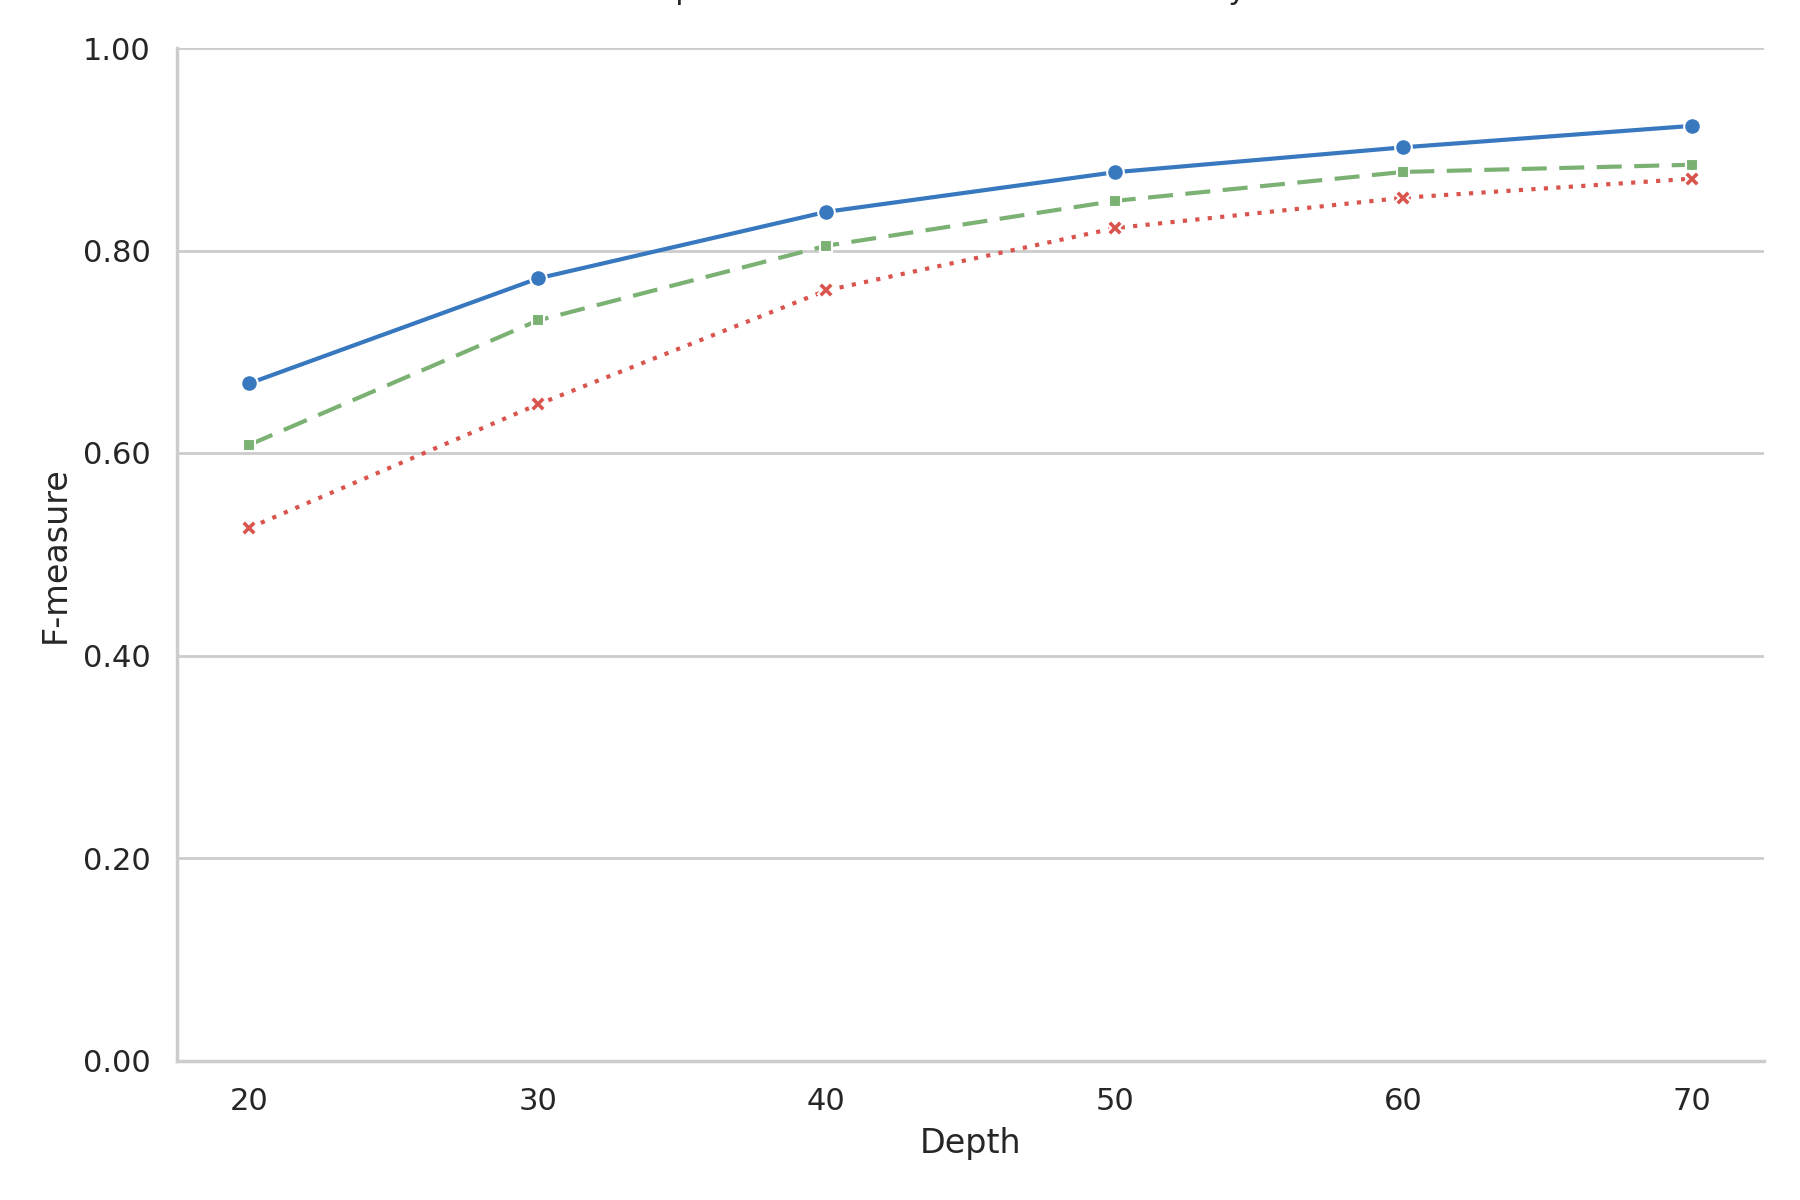

In [400]:
plot_fmeasure_by_depth(summary_df, ylim=(0., 1.),
                       save=figure_dir / "f-measures-by-depth.pdf")

In [329]:
rocs = read_vcfeval_rocs(synthetic_experiments, raw=True)

<IPython.core.display.Javascript object>


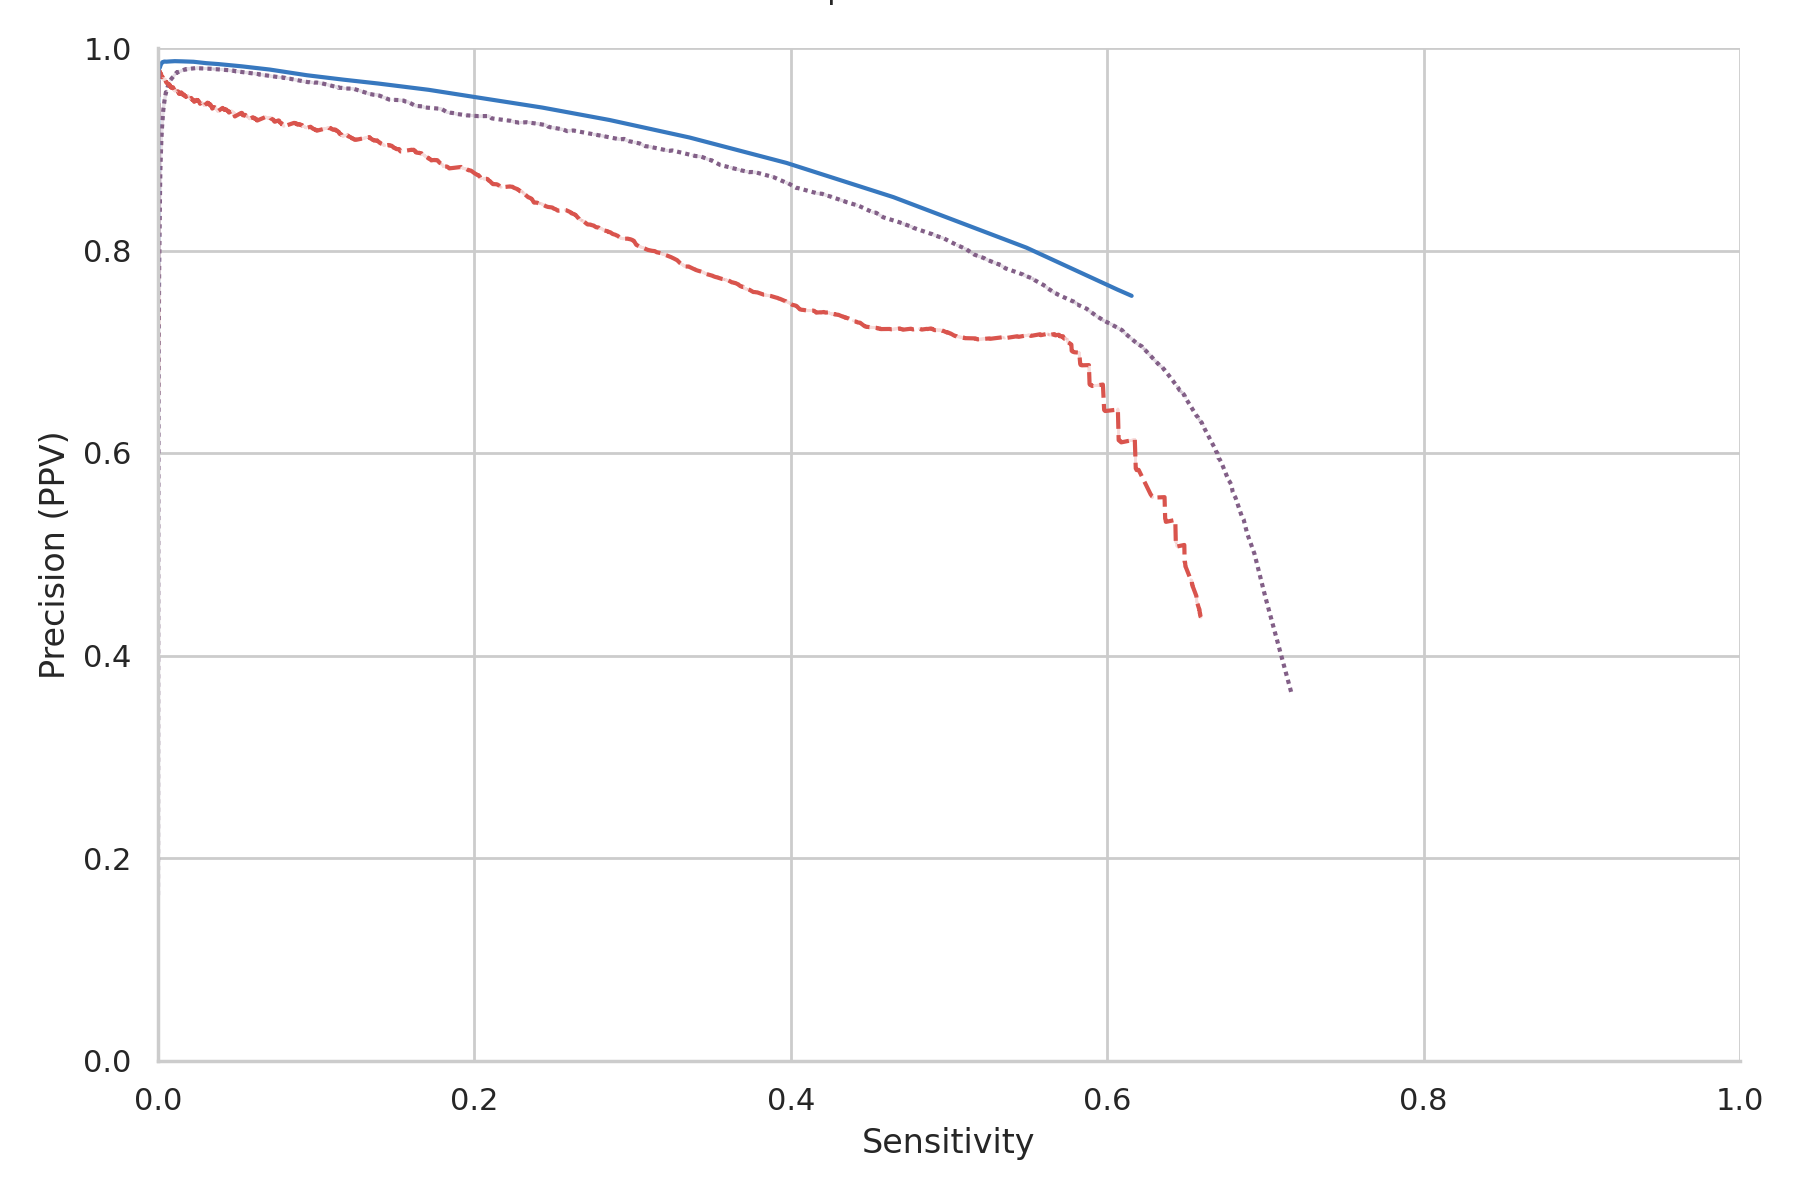

In [334]:
plot_precision_recall(rocs.query('Depth==20'), xlim=(0., 1.), ylim=(0., 1.))

<IPython.core.display.Javascript object>


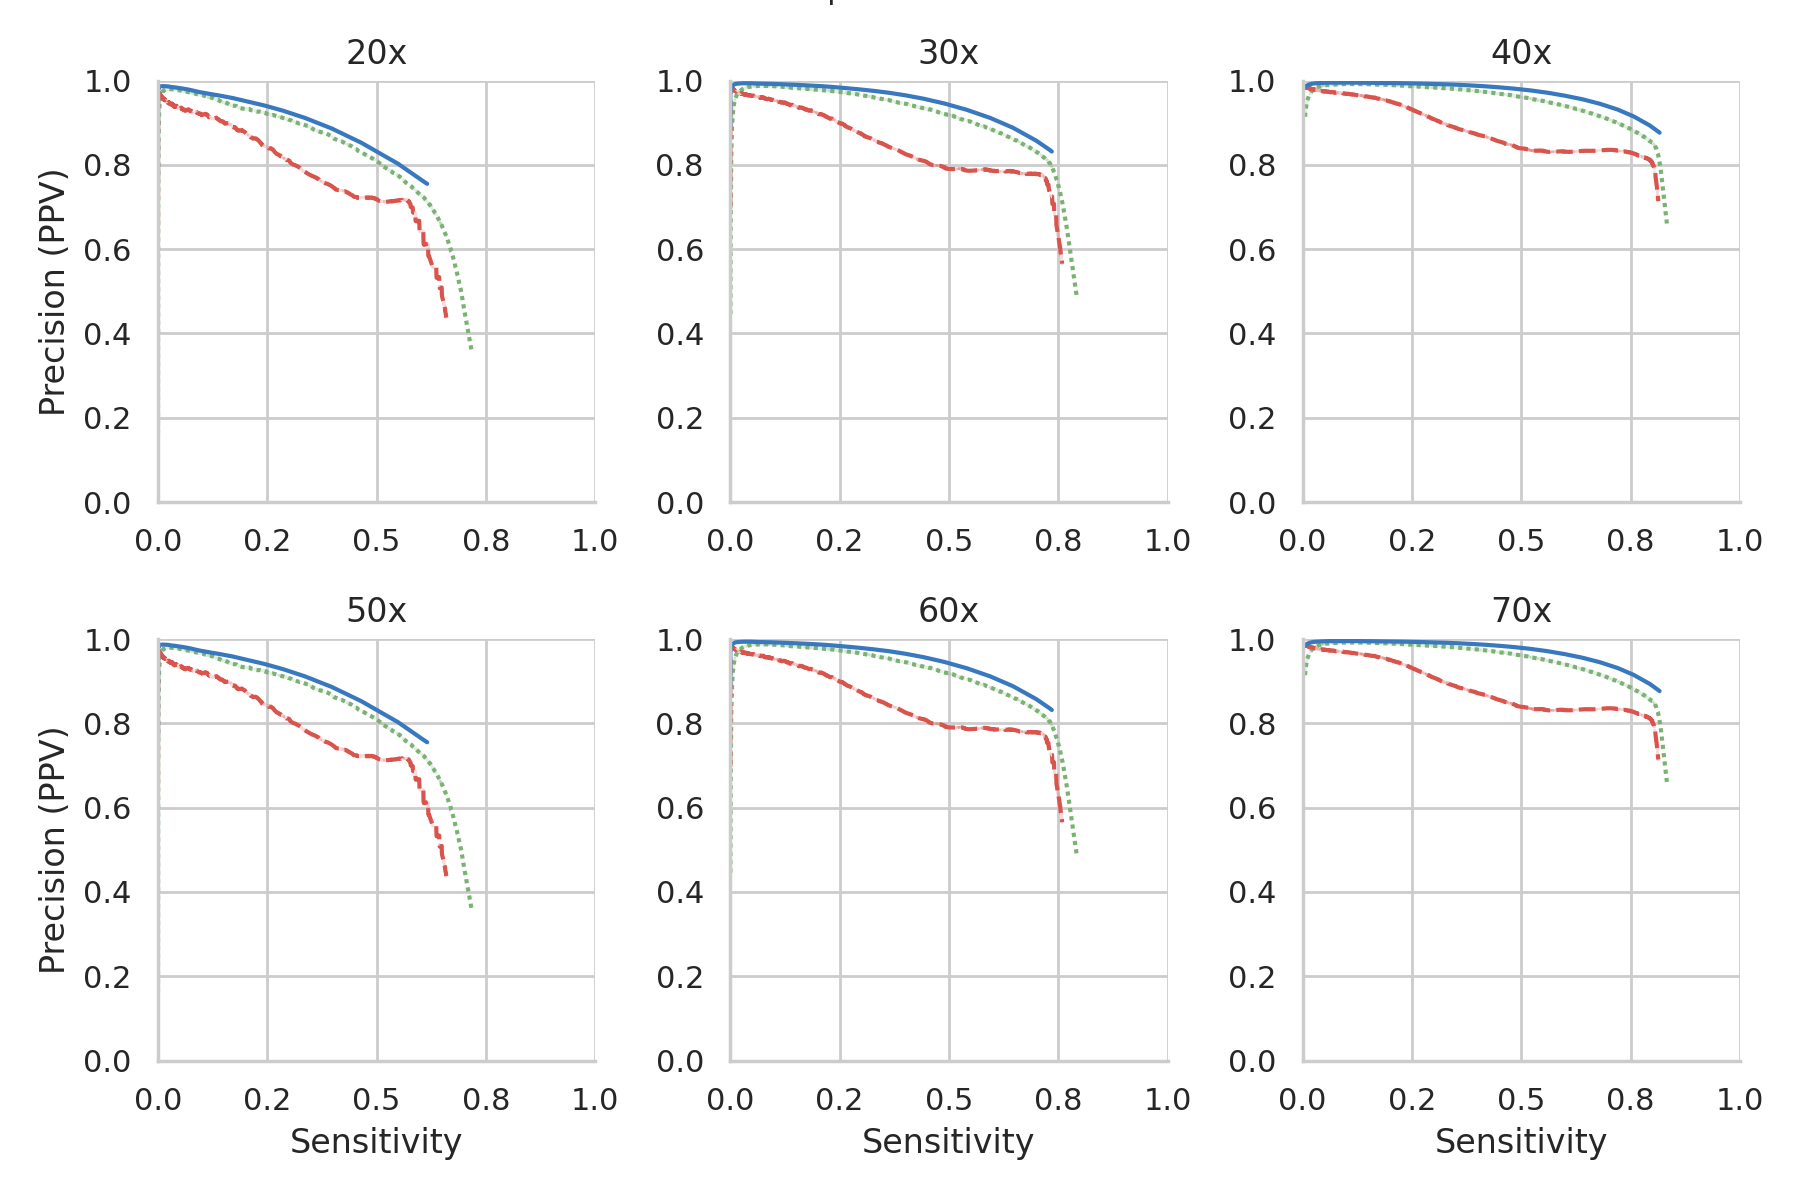

In [401]:
depths = rocs["Depth"].unique()
plot_precision_recalls([rocs.query("Depth==" + str(depth)) for depth in depths],
                       titles=[str(depth) + 'x' for depth in depths],
                       ncols=3,
                       xlims=(0., 1.), ylims=(0., 1.),
                       save=figure_dir / "synthetic-tetraploid-pr-curves.pdf")

In [395]:
def read_biallelic_gt_errors(vcfeval_dir, ploidy):
    fn_stats = read_variant_stats(vcfeval_dir / "fn.vcf.gz")["copy_numbers"]
    fp_stats = read_variant_stats(vcfeval_dir / "fp.vcf.gz")["copy_numbers"]
    data = []
    total_fn, total_fp = 0, 0
    for ref_copies in range(0, ploidy):
        alt_copies = ploidy - ref_copies
        gt = ref_copies * 'A' + alt_copies * 'a'
        fn = fn_stats[alt_copies] if alt_copies in fn_stats else 0
        fp = fp_stats[alt_copies] if alt_copies in fp_stats else 0
        data += [[gt, "FN", fn], [gt, "FP", fp]]
        total_fn += fn
        total_fp += fp
    for d in data:
        if d[1] == "FN":
            d.append(float(d[-1]) / total_fn)
        else:
            d.append(float(d[-1]) / total_fp)
    return pd.DataFrame(data, columns=["GT", "Error", "Count", "Fraction"])

def read_biallelic_error_profiles(experiments, raw=False):
    return read_vcfeval_df_helper(experiments, lambda experiment, d: read_biallelic_gt_errors(d, 2 * len(experiment["samples"])), raw=raw)

In [404]:
raw_biallelic_errors = read_biallelic_error_profiles(synthetic_experiments, raw=True)

<IPython.core.display.Javascript object>


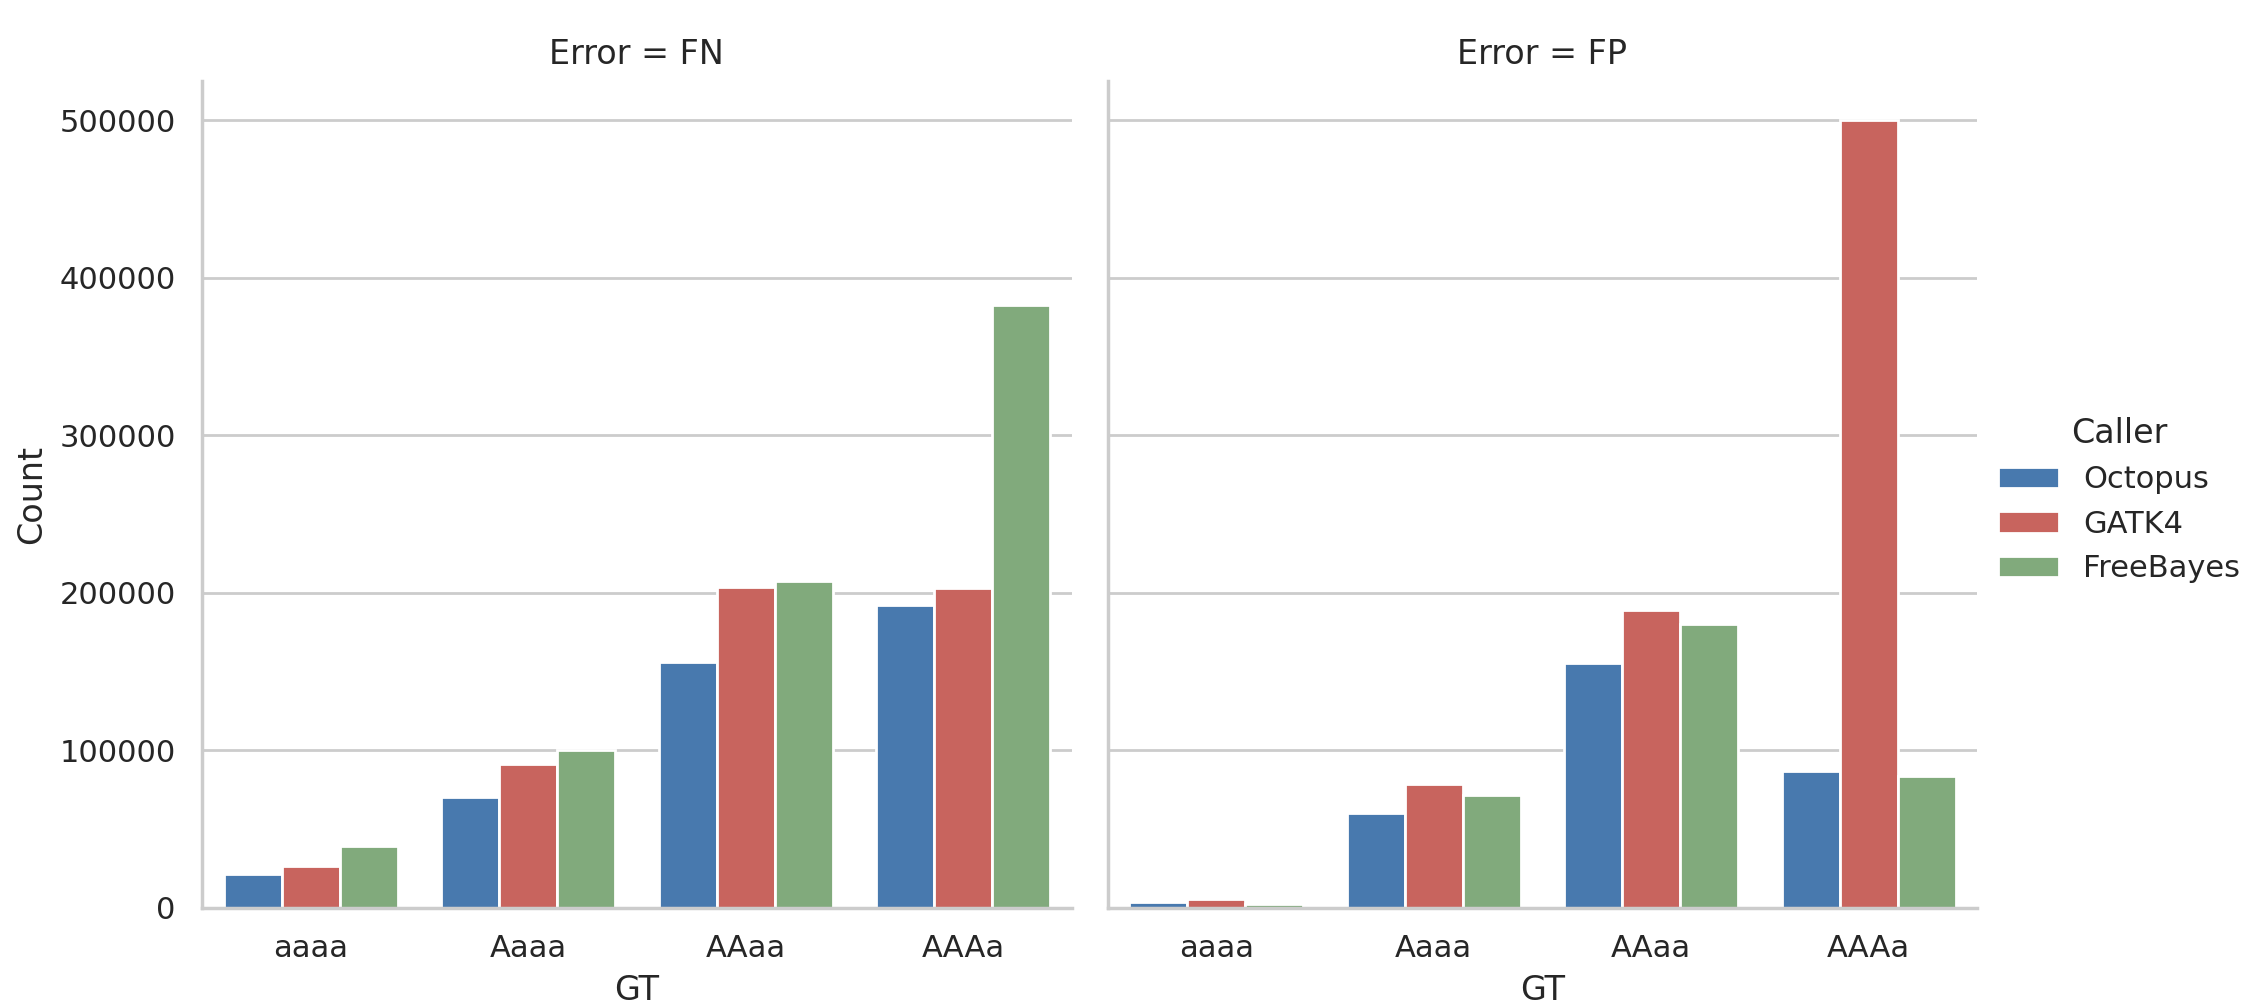

In [402]:
sns.catplot(x="GT", y="Count",
            hue="Caller", col="Error",
            palette=caller_colours,
            kind='bar',
            data=biallelic_errors.query("Depth==70"))

<IPython.core.display.Javascript object>


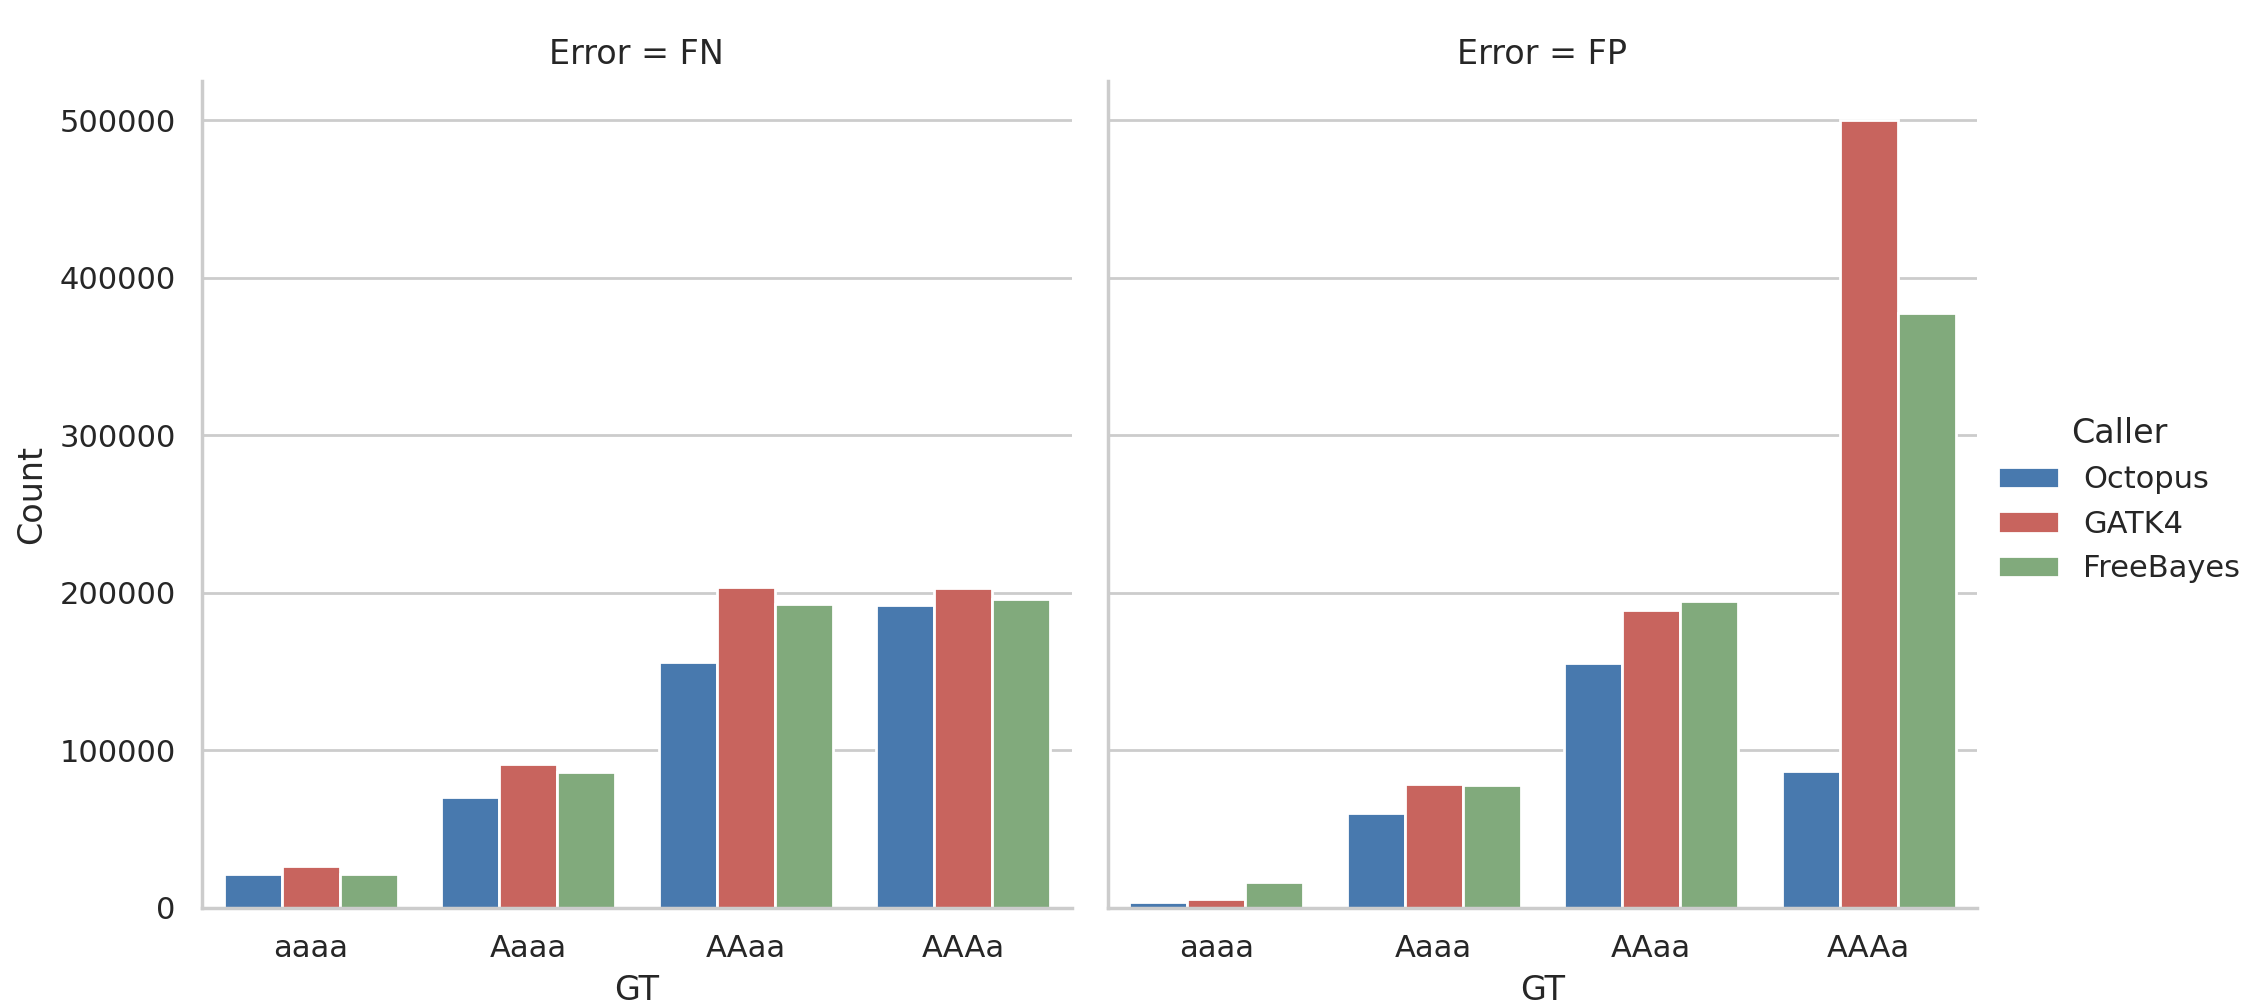

In [405]:
sns.catplot(x="GT", y="Count",
            hue="Caller", col="Error",
            palette=caller_colours,
            kind='bar',
            data=raw_biallelic_errors.query("Depth==70"))

In [213]:
pacbio_experiment = {
    "reference": "hs38DH",
    "samples": ["HG003", "HG004"],
    "library": "PacBioHiFi",
    "depth": 70,
    "callers": all_callers,
    "calling_regions": "autosomes",
    "caller_options": {
        "Octopus": {
            "--max-genotypes": 10000,
            "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
        }
    }
}

In [237]:
run_experiment(pacbio_experiment)

bin/octopus/bin/octopus -R data/references/hs38DH.fa -I data/bam/HG003-HG004.PacBioHiFi.70x.hs38DH.bam -P 4 -t data/references/hs38DH.autosomes.bed --threads 20 -o results/vcf/HG003-HG004.PacBioHiFi.70x.hs38DH.Octopus.vcf.gz --max-genotypes 10000 --config bin/octopus/resources/configs/PacBioCCS.config
qsub -cwd -V -N octopus -j y -o log/octopus_54109.log -P lunter.prjc -q long.qf -pe shmem 20 tmp/octopus_54109.sh
bin/gatk --java-options "-Xmx80g -XX:ParallelGCThreads=1 HaplotypeCaller" --native-pair-hmm-threads 20 -R data/references/hs38DH.fa -I data/bam/HG003-HG004.PacBioHiFi.70x.hs38DH.bam -L data/references/hs38DH.autosomes.bed -ploidy 4 -O results/vcf/HG003-HG004.PacBioHiFi.70x.hs38DH.GATK4.vcf.gz
qsub -cwd -V -N gatk -j y -o log/gatk_17274.log -P lunter.prjc -q short.qf -pe shmem 1 tmp/gatk_17274.sh
qsub -cwd -V -N gatk -j y -o log/gatk_41319.log -P lunter.prjc -q short.qf -pe shmem 1 tmp/gatk_41319.sh
qsub -cwd -V -N gatk -j y -o log/gatk_94578.log -P lunter.prjc -q short.qf -pe 

KeyboardInterrupt: 

In [238]:
pacbio_single_sample_experiments = [
    {
        "reference": "hs38DH",
        "samples": ["HG002"],
        "library": "PacBioHiFi",
        "depth": 35,
        "callers": all_callers,
        "calling_regions": "autosomes",
        "caller_options": {
            "Octopus": {
                "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
            }
        }
    },
    {
        "reference": "hs38DH",
        "samples": ["HG003"],
        "library": "PacBioHiFi",
        "depth": 35,
        "callers": all_callers,
        "calling_regions": "autosomes",
        "caller_options": {
            "Octopus": {
                "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
            }
        }
    },
    {
        "reference": "hs38DH",
        "samples": ["HG004"],
        "library": "PacBioHiFi",
        "depth": 35,
        "callers": all_callers,
        "calling_regions": "autosomes",
        "caller_options": {
            "Octopus": {
                "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
            }
        }
    },
]

In [239]:
run_experiments(pacbio_single_sample_experiments, asynchronous=True)

bin/pbmm2 align data/references/hs38DH.fa data/fastq/HG002_35x_PacBio_14kb-15kb.fastq.gz data/bam/HG002.PacBioHiFi.35x.hs38DH.bam --preset HIFI -j 20 -J 10.0 --rg @RG\tID:None\tSM:HG002\tLB:POLYPLOID\tPL:PacBioHiFi --sort
bin/pbmm2 align data/references/hs38DH.fa data/fastq/HG003_35x_PacBio_14kb-15kb.fastq.gz data/bam/HG003.PacBioHiFi.35x.hs38DH.bam --preset HIFI -j 20 -J 10.0 --rg @RG\tID:None\tSM:HG003\tLB:POLYPLOID\tPL:PacBioHiFi --sortqsub -cwd -V -N pbmm2 -j y -o log/pbmm2_75848.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/pbmm2_75848.sh

qsub -cwd -V -N pbmm2 -j y -o log/pbmm2_28258.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/pbmm2_28258.sh
bin/pbmm2 align data/references/hs38DH.fa data/fastq/HG004_35x_PacBio_14kb-15kb.fastq.gz data/bam/HG004.PacBioHiFi.35x.hs38DH.bam --preset HIFI -j 20 -J 10.0 --rg @RG\tID:None\tSM:HG004\tLB:POLYPLOID\tPL:PacBioHiFi --sort
qsub -cwd -V -N pbmm2 -j y -o log/pbmm2_78765.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/pbmm2_78765.sh
bin/oct

Process Process-68:
Process Process-67:
Process Process-69:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/gpfs3/well/gerton/dan/apps/brew/opt/python@3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs3/well/gerton/dan/apps/brew/opt/python@3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs3/well/gerton/dan/apps/brew/opt/python@3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/gpfs3/well/gerton/dan/apps/brew/opt/python@3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs3/well/gerton/dan/apps/brew/opt/python@3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/gpfs3/well/gerton/dan/apps/brew/opt/python@3.8/lib/python3.8/multiprocessing/process.py"